# Import des bibliothèques


In [13]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC  
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_curve, auc ,f1_score
)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import chromadb
import joblib

# Import des donnes depuis chromaDB


In [14]:

client = chromadb.PersistentClient(path="/opt/airflow/data/chroma_dataBase")

train_collection = client.get_or_create_collection("avis_train")
test_collection  = client.get_or_create_collection("avis_test")

train_results = train_collection.get(
    include=["metadatas", "embeddings", "documents"]
)

x_train = np.array(train_results["embeddings"])
y_train = [m["label"] for m in train_results["metadatas"]]
train_texts = train_results["documents"]

test_results = test_collection.get(
    include=["metadatas", "embeddings", "documents"]
)

x_test = np.array(test_results["embeddings"])
y_test = [m["label"] for m in test_results["metadatas"]]
test_texts = test_results["documents"]



# Import de LabelEncoder pour encoder Label


In [15]:

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

classes = sorted(list(set(y_train)))
y_test_bin = label_binarize(y_test, classes=classes)
y_train_bin = label_binarize(y_train, classes=classes)
joblib.dump(le,"/opt/airflow/models/encoder.joblib")

['/opt/airflow/models/encoder.joblib']

# Entraînement — Logistic Regression

=== Logistic Regression ===
=== Logistic Regression (avant GridSearch) ===
Accuracy train: 0.8606
Accuracy test : 0.8463
Gap (overfitting): 0.0143
=== Logistic Regression (avant GridSearch) ===
f1 score train: 0.8147
f1 score test : 0.7952
Gap (overfitting): 0.0195


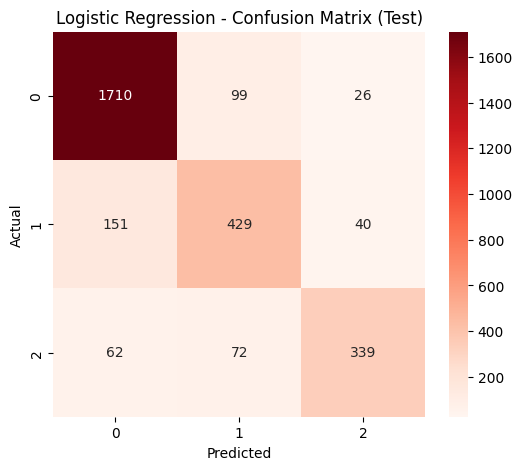

,precision,recall,f1-score,support
negative,0.889236,0.931880,0.910059,1835.000000
neutral,0.715000,0.691935,0.703279,620.000000
positive,0.837037,0.716702,0.772210,473.000000
accuracy,0.846311,0.846311,0.846311,0.846311
macro avg,0.813758,0.780172,0.795182,2928.000000
weighted avg,0.843909,0.846311,0.844005,2928.000000


              precision    recall  f1-score      support
negative       0.889236  0.931880  0.910059  1835.000000
neutral        0.715000  0.691935  0.703279   620.000000
positive       0.837037  0.716702  0.772210   473.000000
accuracy       0.846311  0.846311  0.846311     0.846311
macro avg      0.813758  0.780172  0.795182  2928.000000
weighted avg   0.843909  0.846311  0.844005  2928.000000
 Modèle sauvegardé avec joblib


In [9]:

LogisticRegression_model=LogisticRegression()


LogisticRegression_model.fit(x_train, y_train)
y_pred_train = LogisticRegression_model.predict(x_train)
y_pred_test  = LogisticRegression_model.predict(x_test)
print("="*50)
print(f"=== Logistic Regression ===")
acc_train = accuracy_score(y_train, y_pred_train)
acc_test  = accuracy_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train,average="macro")
f1_test  = f1_score(y_test, y_pred_test,average="macro")



print("="*50)
print("=== Logistic Regression (avant GridSearch) ===")
print("="*50)
print(f"Accuracy train: {acc_train:.4f}")
print(f"Accuracy test : {acc_test:.4f}")
print(f"Gap (overfitting): {acc_train - acc_test:.4f}")
print("="*50)



print("="*50)
print("=== Logistic Regression (avant GridSearch) ===")
print("="*50)
print(f"f1 score train: {f1_train:.4f}")
print(f"f1 score test : {f1_test:.4f}")
print(f"Gap (overfitting): {f1_train - f1_test:.4f}")
print("="*50)


# Création d'un DataFrame pour stocker les métriques
metrics_df = pd.DataFrame({
    "Model": ["LogisticRegression"],
    "Dataset": ["Test"],
    "Accuracy": [ acc_test],
    "F1_score": [ f1_test],
    "Gap": [acc_train - acc_test] 
})

metrics_df.to_csv("/opt/airflow/data/streamlit_df/metrics_logreg.csv", index=False)




cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Reds")
plt.title(f"Logistic Regression - Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


import numpy as np
from sklearn.metrics import confusion_matrix

cm_test = confusion_matrix(y_test, y_pred_test)

# Transformer en DataFrame pour un affichage clair
cm_df = pd.DataFrame(
    cm_test,
    index=[f"Actual_{i}" for i in range(cm_test.shape[0])],
    columns=[f"Pred_{i}" for i in range(cm_test.shape[1])]
)


cm_df.to_csv("/opt/airflow/data/streamlit_df/cm_logreg.csv")




report = classification_report(y_test, y_pred_test, output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df)

from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_test, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print(report_df)

report_df.to_csv("/opt/airflow/data/streamlit_df/report_logreg.csv")




joblib.dump(LogisticRegression_model, "/opt/airflow/models/LogisticRegression_model.joblib")
print(" Modèle sauvegardé avec joblib")    


**Résumé et explication (concise)**  
- Modèle linéaire, régularisé, stable et interprétable.  

**Observation générale**  
- Courbes ROC train ≈ test → comportement stable.  
- Gap Accuracy ≈ 0.014 → peu d’overfitting.  

**Pourquoi cela arrive**  
- LR est régulière → meilleure généralisation.  
- Probabilités bien calibrées.  
- Déséquilibre de classes limité → écart faible entre classes.  

**Conséquences pratiques**  
- Modèle robuste pour production.  
- Probabilités fiables pour calcul de seuils ou scoring.  




In [12]:
print(report_df.head())

           precision    recall  f1-score      support
negative    0.889236  0.931880  0.910059  1835.000000
neutral     0.715000  0.691935  0.703279   620.000000
positive    0.837037  0.716702  0.772210   473.000000
accuracy    0.846311  0.846311  0.846311     0.846311
macro avg   0.813758  0.780172  0.795182  2928.000000


# Courbes ROC — Logistic Regression


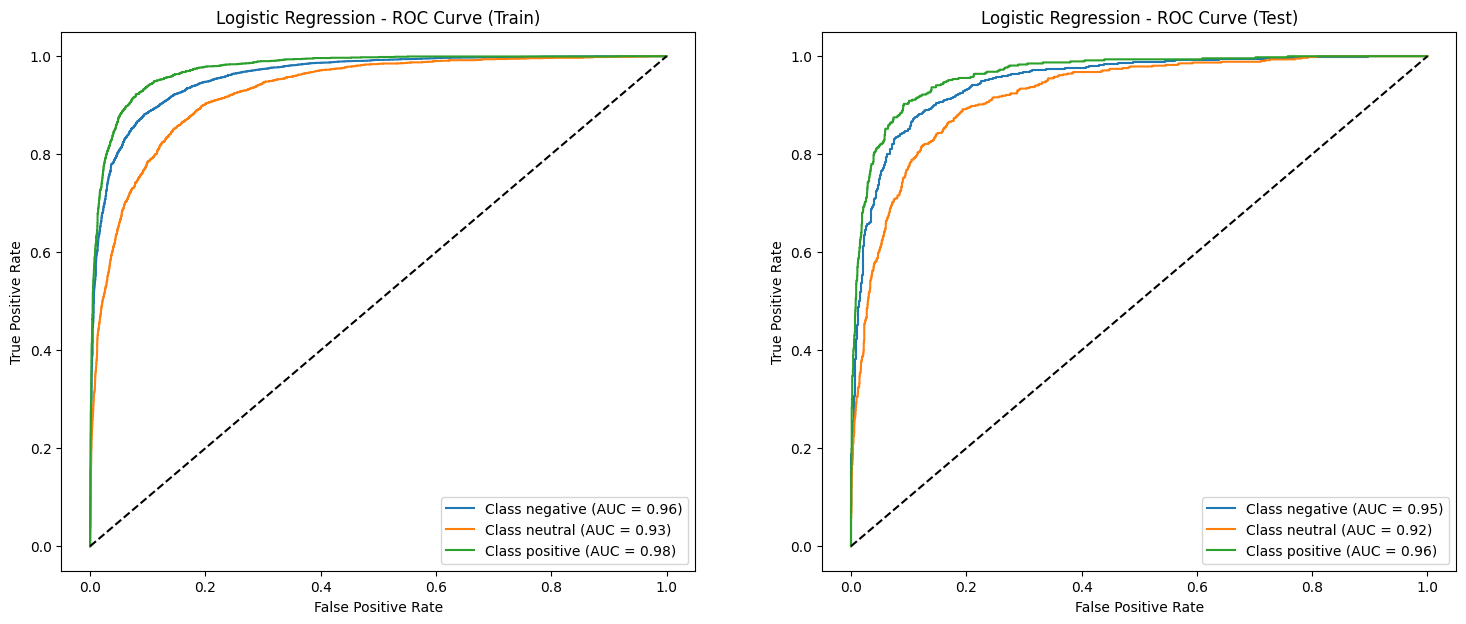

In [ ]:
y_score_train = LogisticRegression_model.predict_proba(x_train)
y_score_test = LogisticRegression_model.predict_proba(x_test)

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_score_train[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("Logistic Regression - ROC Curve (Train)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.subplot(1,2,2)
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_test[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("Logistic Regression - ROC Curve (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.show()




**Observation générale**  
- Courbes ROC train ≈ test → comportement stable.  
- Gap Accuracy ≈ 0.014 → peu d’overfitting. 

# Entraînement — SVC (One-vs-Rest)


=== SVC ===
Accuracy train: 0.8830
Accuracy test : 0.8514
Gap (overfitting): 0.0316


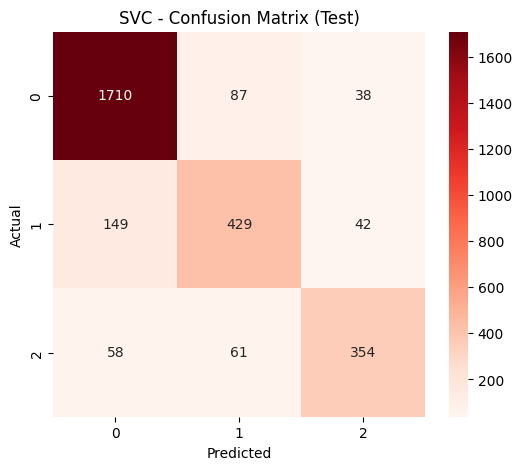

,precision,recall,f1-score,support
negative,0.892019,0.931880,0.911514,1835.000000
neutral,0.743501,0.691935,0.716792,620.000000
positive,0.815668,0.748414,0.780595,473.000000
accuracy,0.851434,0.851434,0.851434,0.851434
macro avg,0.817063,0.790743,0.802967,2928.000000
weighted avg,0.848236,0.851434,0.849133,2928.000000


✅ Modèle sauvegardé avec joblib


In [7]:
svc = SVC(kernel="rbf", probability=True)

svc_model = OneVsRestClassifier(svc)

svc_model.fit(x_train, y_train)

y_pred_train = svc_model.predict(x_train)
y_pred_test  = svc_model.predict(x_test)

print("="*50)
print("=== SVC ===")
print("="*50)
acc_train = accuracy_score(y_train, y_pred_train)
acc_test  = accuracy_score(y_test, y_pred_test)
print(f"Accuracy train: {acc_train:.4f}")
print(f"Accuracy test : {acc_test:.4f}")
print(f"Gap (overfitting): {acc_train - acc_test:.4f}")
print("="*50)

cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Reds")
plt.title("SVC - Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

report = classification_report(y_test, y_pred_test, output_dict=True)
display(pd.DataFrame(report).transpose())
joblib.dump(svc_model, "/opt/airflow/models/svc_model.joblib")
print("✅ Modèle sauvegardé avec joblib") 




**Résumé et explication (concise)**  
- Modèle non linéaire, flexible et expressif.  

  

**Pourquoi cela arrive**  
- SVC RBF est très flexible → peut bien séparer le train mais sur-ajuste le bruit.  
- Classes déséquilibrées → écarts de AUC par classe plus importants.  

**Conséquences pratiques**  
- Peut donner de meilleures performances brutes mais moins stable pour production.  
- Nécessite régularisation ou tuning pour réduire overfitting.  



# Courbes ROC — SVC


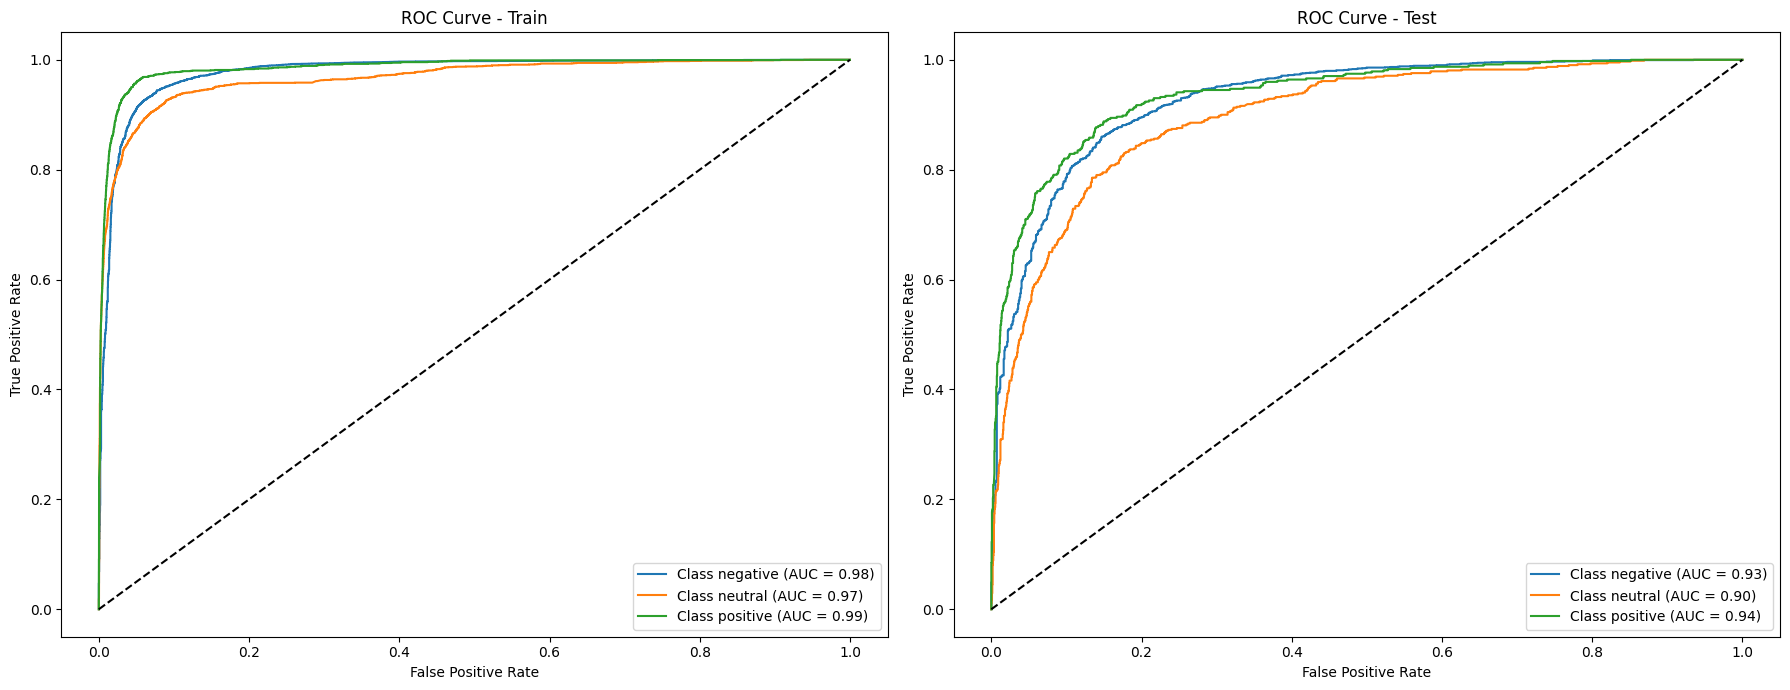

In [34]:
y_score_test  = svc_model.predict_proba(x_test)
y_score_train = svc_model.predict_proba(x_train)

plt.figure(figsize=(18,7))

plt.subplot(1,2,2)
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_test[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve - Test")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1,2,1)
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_score_train[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve - Train")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.tight_layout()
plt.show()


**Observation générale**  
- Courbes ROC train nettement meilleures que test → overfitting probable.  
- Gap Accuracy ≈ 0.09 → surapprentissage.

=== SVC ===
Accuracy train: 0.8689
Accuracy test : 0.8043
Gap (overfitting): 0.0645


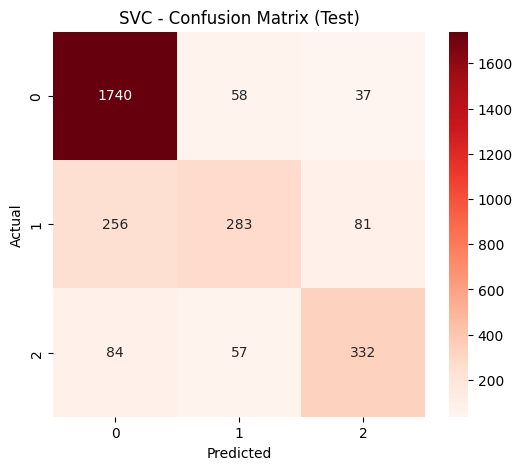

,precision,recall,f1-score,support
negative,0.836538,0.948229,0.888889,1835.000000
neutral,0.711055,0.456452,0.555992,620.000000
positive,0.737778,0.701903,0.719393,473.000000
accuracy,0.804303,0.804303,0.804303,0.804303
macro avg,0.761791,0.702194,0.721425,2928.000000
weighted avg,0.794013,0.804303,0.791018,2928.000000


 Modèle sauvegardé avec joblib


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

y_prob = knn.predict_proba(x_test)[:,1]

y_pred_train = knn.predict(x_train)
y_pred_test  = knn.predict(x_test)



print("="*50)
print("=== SVC ===")
print("="*50)
acc_train = accuracy_score(y_train, y_pred_train)
acc_test  = accuracy_score(y_test, y_pred_test)
print(f"Accuracy train: {acc_train:.4f}")
print(f"Accuracy test : {acc_test:.4f}")
print(f"Gap (overfitting): {acc_train - acc_test:.4f}")
print("="*50)

cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Reds")
plt.title("SVC - Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

report = classification_report(y_test, y_pred_test, output_dict=True)
display(pd.DataFrame(report).transpose())
joblib.dump(knn, "/opt/airflow/models/knn_model.joblib")
print(" Modèle sauvegardé avec joblib") 




##  Évaluation technique et justification du choix du modèle

Dans le cadre de la classification multi-classes de données textuelles basées sur des embeddings, deux modèles supervisés ont été évalués : **Logistic Regression** et **Support Vector Classifier (SVC)**.  
L’analyse repose à la fois sur les performances globales (accuracy), la capacité de généralisation (écart train/test) et la qualité de discrimination mesurée par les **courbes ROC/AUC**.

###  Résultats quantitatifs

| Modèle               | Accuracy Train | Accuracy Test | Gap (Overfitting) |
|----------------------|----------------|---------------|-------------------|
| Logistic Regression  | 0.8606         | 0.8463        | **0.0143**        |
| SVC                  | 0.8830     | **0.8514**    |  **0.0316**      |

###  Analyse des performances

- **Logistic Regression** présente un écart train/test faible, indiquant une bonne capacité de généralisation et un comportement stable face aux données non vues.
- **SVC** atteint une accuracy plus élevée sur le jeu d’entraînement et légèrement supérieure sur le jeu de test, mais au prix d’un écart plus important, traduisant un risque de surapprentissage.
- La différence d’accuracy sur le jeu de test entre les deux modèles reste marginale, tandis que la différence de stabilité est significative.

###  Analyse ROC / AUC

- Les courbes ROC ont été calculées selon une approche **One-vs-Rest**, avec binarisation des labels et utilisation des probabilités de sortie.
- **Logistic Regression** montre des courbes ROC plus régulières et des valeurs d’AUC homogènes entre les classes, ce qui indique une capacité de discrimination stable.
- **SVC** présente des variations plus marquées des AUC selon les classes, suggérant une sensibilité accrue au bruit et au déséquilibre des données.
- La cohérence des AUC entre entraînement et test pour Logistic Regression confirme sa robustesse.

###  Choix du modèle

Au regard de l’ensemble des métriques (accuracy, généralisation et ROC/AUC), **Logistic Regression** est retenue comme modèle final.  
Ce choix privilégie la stabilité, la robustesse et la fiabilité des probabilités prédites, des critères essentiels pour une mise en production dans un contexte NLP réel.

> **Conclusion technique :** Le modèle sélectionné maximise la capacité de généralisation et la cohérence des performances, plutôt que la performance brute sur le jeu d’entraînement.
